# Homework 3: Mining Data Streams
## Computation of Geometric Centralities with HyperBall
Date: *27.11.2021.*<br>
Authors: *[Simon Langrieger, simlan@kth.se]* *[Ivan Klabucar, klabucar@kth.se]*

### Introduction

In this assignment we implement the hyperball algorithm in order to estimate two different geometric centralities for nodes of a given directed graph. These measures give a sense of "importance" of the nodes of a graph and are used to locate nodes of high importance or influence depending on the exact problem at hand. In a social media context this might translate into finding accounts with largest potential reach, or in a transport domain it might equate to finding a transit center that's crucial to everyday operations. 

Our algorithm calculates the Closeness centrality and the Harmonic centrality for every node of a graph, but it is important to note that the information provided by the HyperBalls can also be used to compute other centrality measures such as the Lin’s centrality as well. The implemented algorithm is described in the <a href='https://arxiv.org/pdf/1308.2144v2.pdf'>provided paper</a>.

The problem with caluclating the exact value of these centralities arises from the enormous sizes of real life graphs that have to be analyzed such as social media or transit networks. Brute force simply isn't a viable option. The Hyperball algorithm offers a solution to this problem by efficiently providing good estimates of these measures. It does this, according to [1], in quasi-linear time $O(p m\log{}n)$ where p and m are the number of buckets of the hyperloglog counters and edges respectively, and with a reasonable space complexity of $(1 + o(1)) · p  \log{\log{}}(n/p)$, n=number of nodes. Also, such large networks might not be practical to be kept in memory in their entirety, and it might be more feasible to process them as streams. Fortunately, the Hyperball algorithm is well suited to this task and can process the graphs as streams.

### Centrality measures

Closeness centrality of node x:<br><br>
<font size="5">
$$\frac{1}{\sum_{d(y,x)<\infty}d(y,x)}$$
</font>

The closeness centrality of some node x is the reciprocal value of the sum of distances to x from all coreachable nodes y.<br><br><br>

Harmonic centrality of node x:<br><br>
<font size="5">
$$\sum_{d(y,x)<\infty,y \neq x}\frac{1}{d(y,x)}$$
</font>

The harmonic centrality of some node x is the sum of reciprocal values of the distances to x from all coreachable nodes y.<br>


## Hyperballs

The way the algorithm gathers information about distances between nodes is by iteratively estimating hyperballs of increasing radius for every node. A hyperball of node x is defined as:

<div>
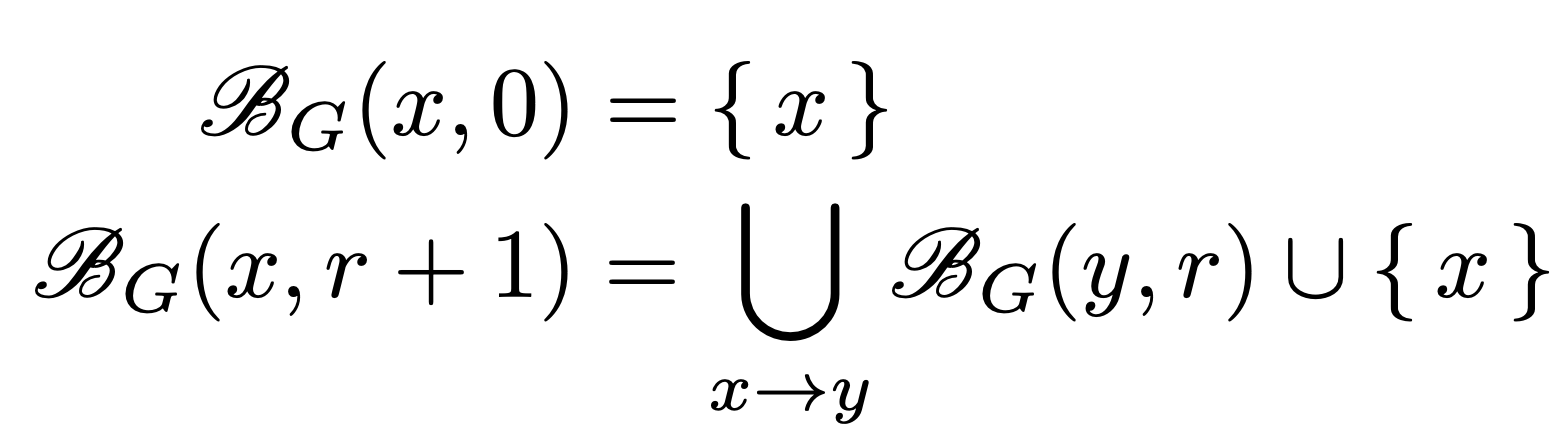
</div>

In other words a hyperball of radius r around node x is the set of nodes reachable from x in r steps or less.

In each step k of the Hyperball algorithm the sizes of all hyperballs of radius k are estimated and then combined with the estimates from the previous step to approximate the value: <br>
$\mid \{y \mid d(x,y) = t\} \mid$<br>

This is of course done by taking the difference of the sizes of two consecutive hyperballs:






<div>
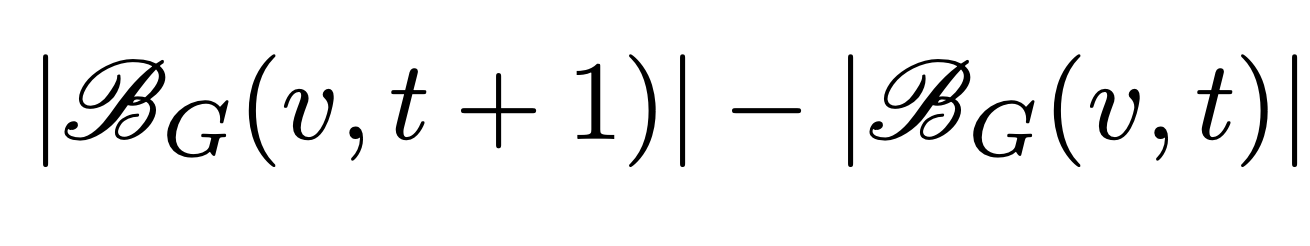
</div>

## Hyperloglog counters

To estimate the sizes of hyperballs, a counter capable of estimating the number of distinct elements in a stream is needed. However, since hyperballs are recurisively constructed as unions of hyperballs of smaller radiuses, the counters also need to support the union operation. In other words, we need to be able to construct a new counter out of two other counters. Hyperloglog counters are suitable for this purpose, as the union operation is done by maximizing the values in their respective buckets. 

## Running the code

To run the code simply open this python notebook in jupyter.<br>

For example:
`> jupyter notebook`

and then open the notebook in the application that opens and proceed to run all the cells. The algorithm can take quite a while.

## Demonstration of results

We employ the algorithm on the Gnutella peer-to-peer network dataset, which can be accessed via this <a href='http://konect.cc/networks/p2p-Gnutella08/'>link</a>. For this dataset, we also calculate the exact centrality measures and compare them to the results provided by out Hyperball algorithm. The Gnutella peer-to-peer network is composed out of 62586 nodes and 147892 edges.

The same experiment is then repeated on the EU email communication network dataset available via this <a href='https://snap.stanford.edu/data/email-EuAll.html'>link</a>. This network is composed out of 265214 nodes and 420045 edges.

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
from functions import *
import networkx as nx
import time

In [2]:
filename = "p2p-Gnutella08.txt"
data = np.genfromtxt("./data/" + filename, dtype='int')

In [3]:
# we need an inverted graph for the algorithm so instead of saving V -> W we store V <- W
V, E = set(), dict()
G = nx.DiGraph()
for (v, w) in data:
    if w not in E:
        E[w] = set()
    E[w].add(v)
    G.add_edge(w, v)
    V.add(v)
    V.add(w)
graph = V, E

### Run Hyperball on Gnutella dataset:

In [4]:
ball = Hyperball()
ball.reset()
start = time.time()
result = ball.run(graph, centrality='h')
end = time.time()
print(f'Hyperball done in: {end - start}s.')


iteration: 1, changed counters: 6194
iteration: 2, changed counters: 6048
iteration: 3, changed counters: 6018
iteration: 4, changed counters: 6012
iteration: 5, changed counters: 6015
iteration: 6, changed counters: 5970
iteration: 7, changed counters: 5741
iteration: 8, changed counters: 4887
iteration: 9, changed counters: 3055
iteration: 10, changed counters: 1440
iteration: 11, changed counters: 640
iteration: 12, changed counters: 303
iteration: 13, changed counters: 124
iteration: 14, changed counters: 57
iteration: 15, changed counters: 20
iteration: 16, changed counters: 8
iteration: 17, changed counters: 4
iteration: 18, changed counters: 1
Hyperball done in: 11.597777843475342s.


### Run Brute force on Gnutella dataset and compare:

In [7]:
start = time.time()
distances = dict(nx.shortest_path_length(G))
end = time.time()

print(f'Brute force done in: {end - start}s.')

diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
print(f'\nMaximal shorthest path: {diameter}\n')

print('Node: HYBERBALL CENTRALITY, REAL CENTRALITY, DIFFERENCE')
i = 0
for v in V:
    if i == 50: break
    harmonic_centrailty = 0
    for v2 in distances[v]:
        if v2 == v: continue
        harmonic_centrailty += 1/distances[v][v2]
    i += 1
    print(f'{v}: est: {result[v]}, real: {harmonic_centrailty}, diff: {result[v] - harmonic_centrailty}')

Brute force done in: 27.466520071029663s.

Maximal shorthest path: 20

Node: HYBERBALL CENTRALITY, REAL CENTRALITY, DIFFERENCE
0: est: 0, real: 0, diff: 0
1: est: 0.0, real: 1.0, diff: -1.0
2: est: 352.576996185914, real: 405.77976190477386, diff: -53.20276571885984
3: est: 702.1805672165581, real: 755.5523809523776, diff: -53.3718137358195
4: est: 684.7521449206524, real: 752.1095238095202, diff: -67.35737888886774
5: est: 699.1469150490155, real: 778.2523809523839, diff: -79.10546590336833
6: est: 0.0, real: 1.0, diff: -1.0
7: est: 684.9389378361144, real: 749.3761904761864, diff: -64.43725264007196
8: est: 635.1268340712885, real: 734.1976190476132, diff: -99.07078497632472
9: est: 684.2467146027407, real: 718.5619047619009, diff: -34.31519015916024
10: est: 510.3932699024646, real: 563.4869047619014, diff: -53.093634859436804
11: est: 336.793301318292, real: 366.7031746031838, diff: -29.90987328489183
12: est: 288.41093258856563, real: 312.27745310244643, diff: -23.8665205138808
13

As we can see the Hyperball algorithms provides reasonable estimates for the harmonic centrality and in better time than brute force calculation. An interesting thing to note is that the algorithm consistently underestimates the actual centrality. This may be because the Hyperloglog counter was designed to measure cardinalities larger than $10^9$ in contrast to the very small cardinalities that we have measured with it (in the order from couple thousand to ten thousand). In our algorithm we use $2^6$ buckets for every counter which corresponds to the bias correction factor of $\alpha_{m} = 0.709$. It may also be the case that the way we hash our elements is not exactly in line with assumptions made in the calculation of $\alpha_{m}$, and in our case the actual correction might need to be larger.

Also, to brute force all the centralities we computed all shortest paths between all nodes. This means we also computed the longest shortest path between two nodes and it is of length 20. This is also estimated reasonably by our Hyperball algorithm since it lasted 18 iterations.

### Run Hyperball on email-EuAll dataset:

In [3]:
filename_email = "email-EuAll.txt"
data_email = np.genfromtxt("./data/" + filename_email, dtype='int')
# we need an inverted graph for the algorithm so instead of saving V -> W we store V <- W
V2, E2 = set(), dict()
#G2 = nx.DiGraph()
for (v, w) in data_email:
    if w not in E2:
        E2[w] = set()
    E2[w].add(v)
    #G2.add_edge(w, v)
    V2.add(v)
    V2.add(w)
graph2 = V2, E2

# start = time.time()
# distances2 = dict(nx.shortest_path_length(G2))
# end = time.time()
#print(f'Brute force done in: {end - start}s.')
print(f'Brute force takes more than 20 minutes.')

ball2 = Hyperball()
ball2.reset()
start = time.time()
result2 = ball2.run(graph2, centrality='h')
end = time.time()
print(f'Hyperball done in: {end - start}s.')

Brute force takes more than 20 minutes.
iteration: 1, changed counters: 73767
iteration: 2, changed counters: 52124
iteration: 3, changed counters: 52099
iteration: 4, changed counters: 52101
iteration: 5, changed counters: 52090
iteration: 6, changed counters: 49684
iteration: 7, changed counters: 11821
iteration: 8, changed counters: 692
iteration: 9, changed counters: 36
Hyperball done in: 113.59350514411926s.


For the larger dataset we were not able to compute the brute force solution as the kernel crashed before the computation was complete whenever we tried to run it. We do know, however, that it lasts longer than 20 minutes. In comparison the Hyperball algorithm finishes in only 113 seconds.  

## Bonus Questions

1. What were the challenges you have faced when implementing the algorithm?

Understanding the paper was somewhat difficult, especially because the data sream counter used wasn't the more simple Flajolet–Martin counter, but rather the HyperLogLog counter. It does run on a similar principle and after getting more intuition about how it worked from various resources available on the internet we were able to implement it. Our first version of the algorithm also had a bug which took us some time to catch. When we converted the hashed value (bytes) to a string we lost the leading zeros because of the methods we used. This broke our algorithm as all the binary strings began with 1.<br><br>

2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.

The algorithm can be parallelized without much intervetion. Every step of the algorithm involves estimatimating hyperballs of some radius r for all nodes. The approximation of all these hyperballs are independant of one another, since they only depend on the hyperballs from the previous step and graph structure. That means that every step of the algorithm can be spread over however many cores are available, by assigning an equal number of nodes to each core. Of course, to move on to the next step of the algorithm it is needed to wait for all cores to finish.<br><br>

3. Does the algorithm work for unbounded graph streams? Explain.

The algorithm in this form does not work for unbounded graph streams. Since estimates of hyperballs of radius r are constructed from earlier estimates, this means that whenever an effectively new edge is introduced to the graph the earlier estimates become outdated and essentially wrong. This also renders the more recent estimates wrong since they were recurisvely calculated from earlier estimates. For example let's say that in an unbounded grap stream at some point a new edge is introduced that creates a new path of size k. If our algorithm has already calculated hyperballs with radius greater than k this renders all the estimates outdated. The source of the problem is that to estimate all hyperballs of a certain radius a pass through the entire data is needed, if at a later step the data changes it also means that all the hyperballs need to be recomputed.<br><br>

4. Does the algorithm support edge deletions? If not, what modification would it need? Explain.

The algorithm does not support edge deletions for the exact same reason as in the previous question. An edge deletion effectively reduces the size of AT LEAST one hyperball of radius 1 by 1. But it can of course effect an even greater number of hyperballs with larger radiuses, rendering the computed estimates wrong. We would esentially need to rerun the algorithm from scratch everytime an edge deletion occurs.

# References

[1] P.  Boldi and S. Vigna, In-Core Computation of Geometric Centralities with HyperBall: A Hundred Billion Nodes and Beyond, ICDMW'13. <a href='https://arxiv.org/pdf/1308.2144v2.pdf'>link</a>